In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *
from utils.analysis import * 
PATH_DATASET = '../Dataset/'
#PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

In [2]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

In [3]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,item_id
0,2017-01-08,0,0,12,76,2,0_12_76
1,2017-01-08,0,0,12,149,3,0_12_149
2,2017-01-08,0,0,12,256,3,0_12_256
3,2017-01-08,0,0,12,354,3,0_12_354
4,2017-01-08,0,0,13,149,2,0_13_149


In [4]:
pd.to_datetime('2020-03-29')+ pd.DateOffset(days=7)*3

Timestamp('2020-04-19 00:00:00')

In [5]:
df_sales['DATE'].iloc[0]

'2017-01-08'

In [6]:
N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]

In [7]:
df_sales = fe_dates(df_sales)
df_submission_sample = fe_dates(df_submission_sample)

In [8]:
df_sales = df_sales.merge(df_items,on=['I100'])
df_sales = df_sales.merge(df_stores,on=['S100'])
    
df_submission_sample = df_submission_sample.merge(df_items,on=['I100'])
df_submission_sample = df_submission_sample.merge(df_stores,on=['S100'])



In [9]:
def string_to_categorical(df):
    for name in df.columns:
        aux = df[name].dtype
        if str(aux) in ['str','object']:
            df[name] = df[name].astype('category')
            print(name,aux,df[name].dtype)
    return df

In [10]:
df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_sales             = string_to_categorical(df_sales).copy()
df_submission_sample = string_to_categorical(df_submission_sample).copy()


item_id object category
ID object category
item_id object category


In [11]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,item_id,year,month,day,...,is_year_start,is_quarter_start,is_month_start,is_month_end,I101,I102,I103,S101,S102,S103
0,2017-01-08,0,0,12,76,2,0_12_76,2017,1,8,...,False,False,False,False,2,1,1,1,17,10
1,2017-01-08,0,0,12,149,3,0_12_149,2017,1,8,...,False,False,False,False,2,1,1,1,17,10
2,2017-01-08,0,0,12,256,3,0_12_256,2017,1,8,...,False,False,False,False,2,1,1,1,17,10
3,2017-01-08,0,0,12,354,3,0_12_354,2017,1,8,...,False,False,False,False,2,1,1,1,17,10
4,2017-01-08,0,0,13,149,2,0_13_149,2017,1,8,...,False,False,False,False,2,1,1,1,17,10


In [12]:
def categorical_to_numeric(df):
    cat_columns = df.select_dtypes(['category']).columns
    print(cat_columns)
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    df[cat_columns] = df[cat_columns].astype(int)
    return df

In [13]:
print(df_sales.shape,df_submission_sample.shape)
df_auxiliar = pd.concat([df_sales,df_submission_sample])
df_auxiliar.replace([np.inf, -np.inf, np.nan],0,inplace=True)

df_auxiliar = string_to_categorical(df_auxiliar).copy()

dates = df_auxiliar['DATE'].unique()

date = df_auxiliar['DATE'].min()
maxi = df_auxiliar['DATE'].max()

dict_dates = {}
idx = 0
while(True):    
    if date>maxi:
        break
    dict_dates[date]=idx
    date = date+ pd.DateOffset(days=7)    
    idx = idx+1
    
df_auxiliar['date_block_num'] = df_auxiliar['DATE'].replace(dict_dates)

#df_auxiliar['date_block_num'] = df_auxiliar['year']*12*4+df_auxiliar['month']*4+df_auxiliar['day']//7

#df_auxiliar['date_block_num'] = df_auxiliar['date_block_num']-int(df_auxiliar['date_block_num'].min())+100

df_auxiliar = categorical_to_numeric(df_auxiliar)

df_auxiliar = columns_to_str(df_auxiliar,["S101", "S102","S103","I100","I101","I102","I103","C100","C101"])

df_sales, df_submission_sample = df_auxiliar[:N_sales], df_auxiliar[N_sales:]
print(df_sales.shape,df_submission_sample.shape)

(2749369, 22) (69121, 23)
item_id object category
Index(['item_id', 'ID'], dtype='object')
(2749369, 24) (69121, 24)


In [14]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start'
for cat_col in ["S100", "item_id","S101", "S102","S103","I100","I101","I102","I103","C100","C101"]:
    df_sales[cat_col]             = (df_sales[cat_col].astype(str) +'_'+ cat_col).astype('category')
    df_submission_sample[cat_col] = (df_submission_sample[cat_col].astype(str) +'_'+ cat_col).astype('category')


/tmp/ipykernel_9906/797300667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales[cat_col]             = (df_sales[cat_col].astype(str) +'_'+ cat_col).astype('category')
/tmp/ipykernel_9906/797300667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission_sample[cat_col] = (df_submission_sample[cat_col].astype(str) +'_'+ cat_col).astype('category')


In [15]:
df_sales['date_block_num']

0            0
1            0
2            0
3            0
4            0
          ... 
2749364    161
2749365    162
2749366    162
2749367    162
2749368    164
Name: date_block_num, Length: 2749369, dtype: int64

In [16]:
df_sales.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [17]:
date_block_num_min_sales = df_sales['date_block_num'].min()
date_block_num_max_sales = df_sales['date_block_num'].max()
print(date_block_num_min_sales,date_block_num_max_sales)

aux = df_sales['DATE'].min()
id_aux = 0
for i in range(date_block_num_min_sales,date_block_num_max_sales+1):
    ga = df_sales[df_sales['date_block_num']==i]
    if len(ga)>0:
        date = ga['DATE'].iloc[0]
        #print(date,i)
        if date<aux :
            print('discontinuidad')
            print('before :',aux,id_aux)
            print('actual :',date,i)
        elif date==aux and id_aux !=0:
            print('igualdad')
            print('before :',aux,id_aux)
            print('actual :',date,i)
        else:
            pass
        aux = date
        id_aux =i
    else:
        print('date before',id_aux,aux)
        print('date not exists',i)

0 246
date before 167 2020-03-22 00:00:00
date not exists 168
date before 167 2020-03-22 00:00:00
date not exists 169
date before 167 2020-03-22 00:00:00
date not exists 170
date before 167 2020-03-22 00:00:00
date not exists 171


In [18]:
date_block_num_min_sales = df_auxiliar['date_block_num'].min()
date_block_num_max_sales = df_auxiliar['date_block_num'].max()
print(date_block_num_min_sales,date_block_num_max_sales)

aux = df_auxiliar['DATE'].min()
id_aux = 0
for i in range(date_block_num_min_sales,date_block_num_max_sales+1):
    ga = df_auxiliar[df_auxiliar['date_block_num']==i]
    if len(ga)>0:
        date = ga['DATE'].iloc[0]
        #print(date,i)

0 254


In [19]:
features_names = set(df_sales.columns)-set(['QTT','DATE'])
print(features_names)

{'I103', 'I101', 'day', 'is_quarter_start', 'day_of_year', 'is_year_start', 'S102', 'day_of_week', 'date_block_num', 'is_month_start', 'S103', 'ID', 'C101', 'C100', 'I102', 'year', 'S101', 'month', 'is_month_end', 'S100', 'item_id', 'I100'}


In [20]:
df_submission_sample['DATE'].min(),df_submission_sample['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [21]:
features_names = ['DATE','QTT','date_block_num',"S100", "item_id","S101", "S102","S103","I100","I101","I102","I103","C100","C101",'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start']

In [22]:
df_sales             = df_sales[features_names]
df_submission_sample = df_submission_sample[features_names]


In [23]:
qtt_values = df_sales['QTT']

In [24]:
df_sales['QTT'] = qtt_values*1.0

In [25]:
df_sales['QTT'].head()

0    2.0
1    3.0
2    3.0
3    3.0
4    2.0
Name: QTT, dtype: float64

In [26]:
#df_sales2 = df_sales[df_sales['QTT']<=15].copy()

In [27]:
#df_submission_sample = df_submission_sample[df_submission_sample['S100']==0]

In [28]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Global seed set to 42


In [29]:
df_sales.drop(df_sales[(df_sales['item_id']==167)].index, inplace=True)


In [30]:
df_sales.dtypes

DATE                datetime64[ns]
QTT                        float64
date_block_num               int64
S100                      category
item_id                   category
S101                      category
S102                      category
S103                      category
I100                      category
I101                      category
I102                      category
I103                      category
C100                      category
C101                      category
day_of_week                  int64
day                          int64
is_month_end                  bool
day_of_year                  int64
is_quarter_start              bool
year                         int64
month                        int64
is_year_start                 bool
is_month_start                bool
dtype: object

In [31]:
df_sales.head(5)

,DATE,QTT,date_block_num,S100,item_id,S101,S102,S103,I100,I101,...,C101,day_of_week,day,is_month_end,day_of_year,is_quarter_start,year,month,is_year_start,is_month_start
0,2017-01-08,2.0,0,0_S100,4_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,76_C101,6,8,False,8,False,2017,1,False,False
1,2017-01-08,3.0,0,0_S100,0_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,149_C101,6,8,False,8,False,2017,1,False,False
2,2017-01-08,3.0,0,0_S100,2_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,256_C101,6,8,False,8,False,2017,1,False,False
3,2017-01-08,3.0,0,0_S100,3_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,354_C101,6,8,False,8,False,2017,1,False,False
4,2017-01-08,2.0,0,0_S100,6_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,149_C101,6,8,False,8,False,2017,1,False,False


In [32]:
df_sales

,DATE,QTT,date_block_num,S100,item_id,S101,S102,S103,I100,I101,...,C101,day_of_week,day,is_month_end,day_of_year,is_quarter_start,year,month,is_year_start,is_month_start
0,2017-01-08,2.0,0,0_S100,4_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,76_C101,6,8,False,8,False,2017,1,False,False
1,2017-01-08,3.0,0,0_S100,0_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,149_C101,6,8,False,8,False,2017,1,False,False
2,2017-01-08,3.0,0,0_S100,2_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,256_C101,6,8,False,8,False,2017,1,False,False
3,2017-01-08,3.0,0,0_S100,3_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,354_C101,6,8,False,8,False,2017,1,False,False
4,2017-01-08,2.0,0,0_S100,6_item_id,1_S101,17_S102,10_S103,0_I100,2_I101,...,149_C101,6,8,False,8,False,2017,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749364,2020-02-09,7.0,161,16_S100,2108_item_id,1_S101,18_S102,10_S103,61_I100,0_I101,...,354_C101,6,9,False,40,False,2020,2,False,False
2749365,2020-02-16,2.0,162,16_S100,2109_item_id,1_S101,18_S102,10_S103,61_I100,0_I101,...,76_C101,6,16,False,47,False,2020,2,False,False
2749366,2020-02-16,8.0,162,16_S100,2106_item_id,1_S101,18_S102,10_S103,61_I100,0_I101,...,281_C101,6,16,False,47,False,2020,2,False,False
2749367,2020-02-16,7.0,162,16_S100,2108_item_id,1_S101,18_S102,10_S103,61_I100,0_I101,...,354_C101,6,16,False,47,False,2020,2,False,False


In [33]:
df_sales.columns

Index(['DATE', 'QTT', 'date_block_num', 'S100', 'item_id', 'S101', 'S102',
       'S103', 'I100', 'I101', 'I102', 'I103', 'C100', 'C101', 'day_of_week',
       'day', 'is_month_end', 'day_of_year', 'is_quarter_start', 'year',
       'month', 'is_year_start', 'is_month_start'],
      dtype='object')

In [34]:
sorted(df_submission_sample['date_block_num'].value_counts().index)

[247, 248, 249, 250, 251, 252, 253, 254]

In [35]:
prediction_steps = df_submission_sample['date_block_num'].nunique()
prediction_steps

8

In [46]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 27

training_cutoff = df_sales['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_sales[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="QTT",
    group_ids=["S100", "item_id"],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    
    static_categoricals=["S100", "item_id"],
    
    time_varying_unknown_categoricals=["S100", "item_id","S101", "S102","S103","I100","I101","I102","I103","C100","C101"],
    time_varying_unknown_reals=["date_block_num","QTT",'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start'],
    
    time_varying_known_reals=['date_block_num'],
    time_varying_known_categoricals=[],  
       
    #target_normalizer=GroupNormalizer(
    #    groups=["S100", "item_id"], transformation="softplus"
    #),  # use softplus and normalize by group    
    
    categorical_encoders={"item_id": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          
                          "S100":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "S101": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "S102": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "S103": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "I100": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "I101": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "I102": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "I103": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "C100": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),                          
                          "C101": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         #"date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    #,
    #                      "item_id":pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #                     },
    #'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start']},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [47]:
validation = TimeSeriesDataSet.from_dataset(training, df_sales, predict=True, stop_randomization=True)


In [48]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [49]:
from pytorch_forecasting.metrics import QuantileLoss


In [50]:
from pytorch_forecasting.metrics import SMAPE, MAE

composite_metric = SMAPE() + 1e-4 * MAE()

In [51]:

trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    #loss=SMAPE(),
    
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 97.5k


In [52]:
training.categorical_encoders

{'item_id': NaNLabelEncoder(add_nan=True),
 'S100': NaNLabelEncoder(add_nan=True),
 'S101': NaNLabelEncoder(add_nan=True),
 'S102': NaNLabelEncoder(add_nan=True),
 'S103': NaNLabelEncoder(add_nan=True),
 'I100': NaNLabelEncoder(add_nan=True),
 'I101': NaNLabelEncoder(add_nan=True),
 'I102': NaNLabelEncoder(add_nan=True),
 'I103': NaNLabelEncoder(add_nan=True),
 'C100': NaNLabelEncoder(add_nan=True),
 'C101': NaNLabelEncoder(add_nan=True),
 '__group_id__S100': NaNLabelEncoder(),
 '__group_id__item_id': NaNLabelEncoder()}

tft.requires_grad_ = False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42

Finding best initial lr: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


suggested learning rate: 1.8197008586099832e-06


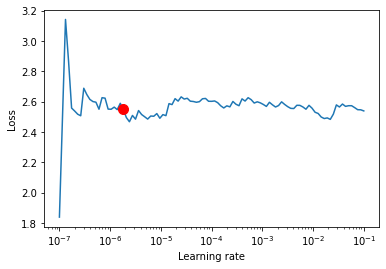

In [53]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [54]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss=pytorch_forecasting.metrics.RMSE(),
    #loss= SMAPE(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 97.5k


In [55]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs= 100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 68.8 K
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 11.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42


Epoch 0:  25%|██▌       | 30/119 [00:08<00:25,  3.50it/s, loss=2.76, v_num=42, train_loss_step=1.780]
Validating: 0it [00:00, ?it/s]
Validating:  81%|████████  | 72/89 [00:58<00:15,  1.12it/s]

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [ ]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

In [ ]:
for i in range(20):
    print(actuals[i],val_predictions[i])


In [ ]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

In [ ]:
df_submission_sample

In [ ]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_sales[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

In [ ]:

last_data = df_sales[df_sales['date_block_num'].isin([idx  -  max_prediction_length for idx in df_submission_sample['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_submission_sample[[col for col in df_submission_sample.columns if 'QTT' not in col]], 
        last_data[['date_block_num','S100', 'item_id',"QTT"]],
        on = ['date_block_num', 'S100', 'item_id',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
last_data

In [ ]:
decoder_data

In [ ]:
new_prediction_data

In [ ]:
df_submission_sample.columns

In [ ]:
predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)

In [ ]:
predictions = pd.DataFrame(predictions.numpy()).T


In [ ]:
ga = predictions.T

In [ ]:
ga

In [ ]:
idx = 1
ga[idx].max(),ga[idx].min()

In [ ]:
len(df_submission_sample['date_block_num'].unique())

In [ ]:
predictions['date_block_num'] = sorted(df_submission_sample['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)

In [ ]:
df_test = df_submission_sample.copy()

In [ ]:
df_test[['date_block_num', 'S100', 'item_id']].sort_values(['date_block_num', 'S100', 'item_id']).reset_index(drop=True)
df_test = df_test.join(predictions['value'])

In [ ]:
df_test

In [ ]:
df_test.drop(columns=['QTT'],inplace=True)
df_test = df_test.rename(columns={"value": "QTT"})

In [ ]:
df_test

In [ ]:
X_train_pred      = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm.predict(X_validation, num_iteration=gbm.best_iteration_)
X_test_pred       = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

X_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_error

X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)
X_submission_pred = np.maximum(X_submission_pred, 0)

df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)

In [ ]:
#X_test_pred[0] = 200

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

In [ ]:
filename_submission= 'submission_NOFILL_good_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = False
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions','no_fill',filename_submission),index=None)

In [ ]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

In [ ]:
df_test['QTT_reference']= result['QTT'].copy()
df_test[['QTT_reference','QTT']][-20:]

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

difference = mean_squared_error(df_test['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)